In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os, sys, glob
from PIL import Image
import io
import pickle
from collections import OrderedDict

In [19]:
dirstem = '/home/dbear/testflex0'
# trials = sorted(glob.glob(dirstem), key=lambda t: int(t.split('_')[-1]))
# trials = {int(trial.split('_')[-1]): trial for trial in trials}
trials = dirstem
!ls `echo $dirstem`

0000.hdf5    0000_img.mp4  0001_id.mp4	 0002.hdf5    0002_img.mp4
0000_id.mp4  0001.hdf5	   0001_img.mp4  0002_id.mp4


0000.hdf5
top keys ['frames', 'static']
num frames: 151
frame data keys ['camera_matrices', 'collisions', 'env_collisions', 'images', 'labels', 'objects', 'particles', 'velocities']
image keys ['_id', '_img']


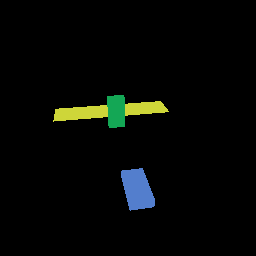

In [21]:
TDW_DIR = trials
TNUM = 0
FILE = "%04d.hdf5" % TNUM
print(FILE)
view_frame = 50
f = h5py.File(os.path.join(TDW_DIR, FILE))

# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']
n_frames = len([k for k in frames.keys()])
print("num frames: {}".format(n_frames))
view_frame = np.minimum(view_frame, n_frames - 1)
frame = frames["%04d" % (view_frame)]
print("frame data keys", [k for k in frame.keys()])
img = frame['images']
print("image keys", [k for k in img.keys()])
_img = Image.open(io.BytesIO(img["_id"][:]))
_img

<IPython.core.display.Javascript object>


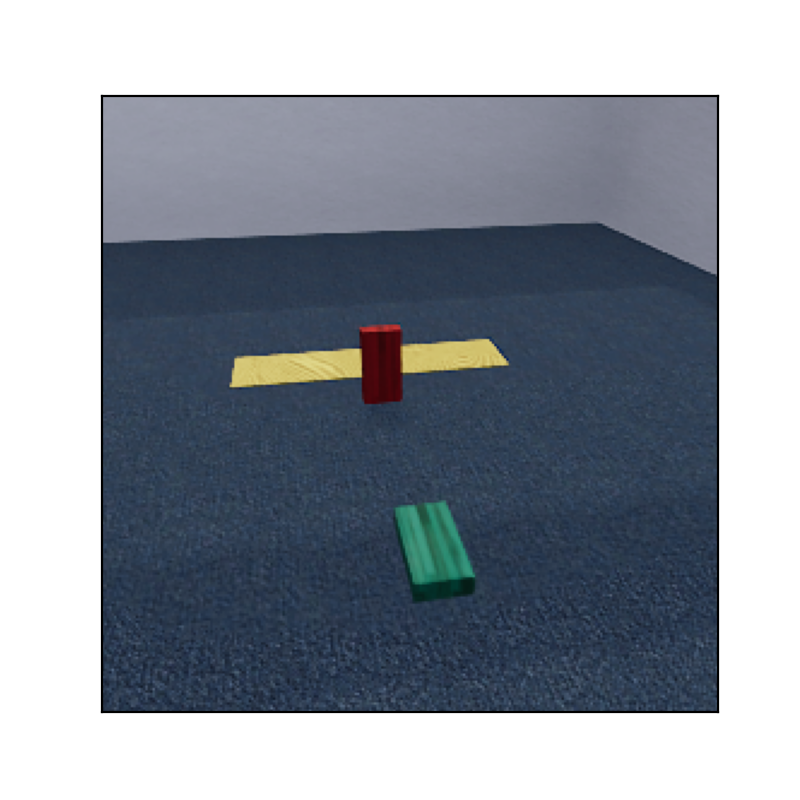

In [22]:
%matplotlib nbagg
SAVE = False

def get_frame(f, idx, imkey='_img', N=n_frames):
    fkeys = sorted([k for k in f['frames'].keys()])
    img = f['frames'][fkeys[idx % N]]['images']
    return np.array(Image.open(io.BytesIO(img[imkey][:]))), len(fkeys)

idx = 0

fig, axes = plt.subplots(figsize=(4,4))
fr0, n_frames = get_frame(f,idx)
im = plt.imshow(fr0, origin='upper')

def animate(*args):
    global idx
    
    fr, N = get_frame(f, idx, '_img')
    im.set_array(fr)
    idx += 1
    idx %= N
    
    return im,

def savegif(ani, directory=TDW_DIR, file=FILE):
    import os
    f = os.path.join(directory, file.split('.')[0]) + ".gif"
    writergif = animation.PillowWriter(fps=48)
    ani.save(f, writer=writergif)

ani = animation.FuncAnimation(fig, animate, interval=10, save_count=n_frames)
plt.xticks([])
plt.yticks([])
plt.show()

if SAVE:
    savegif(ani, TDW_DIR, FILE)

# Check Metadata

In [49]:
skeys = [k for k in f['static'].keys()]
print(skeys)

obj_ids = [oid for oid in f['static']['object_ids']]
print(obj_ids)

['bounciness', 'color', 'distractors', 'dynamic_friction', 'git_commit', 'initial_position', 'initial_rotation', 'mass', 'middle_type', 'model_names', 'object_ids', 'object_segmentation_colors', 'occluders', 'probe_id', 'probe_mass', 'probe_type', 'push_force', 'push_position', 'push_time', 'ramp_base_height', 'ramp_base_id', 'ramp_id', 'randomize', 'room', 'scale', 'scale_x', 'scale_y', 'scale_z', 'seed', 'static_friction', 'stimulus_name', 'target_id', 'target_rotation', 'target_type', 'trial_num', 'trial_seed', 'zone_id']
[1, 2, 5, 4, 3]


In [53]:
key = 'model_names'
meta = f['static'][key]
# meta
print(np.array(meta))

[b'cube' b'cube' b'cube' b'ramp_with_platform_30' b'sphere']


In [56]:
key = 'color'
meta = f['static'][key]
# meta
print(np.array(meta))

[[1.         1.         0.        ]
 [1.         0.         0.        ]
 [0.31014757 0.72983175 0.89883829]
 [0.31014757 0.72983175 0.89883829]
 [0.50468686 0.28183784 0.7558042 ]]


In [63]:
key = 'object_segmentation_colors'
meta = f['static'][key]
# meta
print(np.array(meta))

[[124 128   1]
 [112  21 193]
 [ 66 123 180]
 [ 80   4  29]
 [115  76 184]]


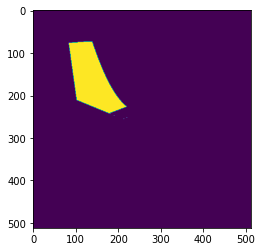

In [69]:
mask = np.array(_img) == meta[3]
plt.imshow(mask.max(axis=-1))

# Frame Data

In [272]:
fs = [k for k in f['frames'].keys()]
print("dynamic keys")
print([k for k in f['frames'][fs[0]].keys()])
print("collision keys")
print([k for k in f['frames'][fs[0]]['collisions'].keys()])

def get_collisions(hf, idx, env_collisions=False):
    fkeys = [k for k in hf['frames'].keys()]
    return hf['frames'][fkeys[idx]]['collisions' if not env_collisions else 'env_collisions']

def find_collisions_frames(hf, cdata='contacts', env_collisions=False):
    n_frames = len([k for k in hf['frames'].keys()])
    collisions = []
    for n in range(n_frames):
        contacts = get_collisions(hf, n, env_collisions)[cdata]
        collisions.append(bool(len(contacts)))
    return np.where(collisions)[0]

def did_fall(hf, idx=-1):
    fkeys = [k for k in hf['frames'].keys()]
    n_frames = len(fkeys)
    if n_frames > 5 and (idx % n_frames > 5):
        return np.array(hf['frames'][fkeys[idx]]["did_fall"])
    else:
        return None

dynamic keys
['camera_matrices', 'collisions', 'env_collisions', 'images', 'labels', 'objects']
collision keys
['contacts', 'object_ids', 'relative_velocities', 'states']


In [273]:
find_collisions_frames(f, 'contacts', False)

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169])

In [403]:
np.array(f['frames'][fs[0]]['objects']['rotations'])

array([[ 4.76518913e-08, -2.22390552e-12,  4.22937588e-11,
         1.00000000e+00],
       [ 3.01082501e-08,  1.30342159e-09, -2.09958273e-09,
         1.00000000e+00],
       [ 1.74940826e-04, -5.40700021e-05, -4.44623567e-02,
         9.99011159e-01],
       [ 2.41519320e-08,  1.47538409e-01, -5.35223155e-09,
         9.89056349e-01],
       [ 1.10243485e-08,  1.20318994e-01, -1.39708325e-08,
         9.92735326e-01],
       [ 2.63911453e-08,  3.43538642e-01,  1.91433536e-09,
         9.39138532e-01]], dtype=float32)

In [429]:
idx = 1
fs = list(f['frames'].keys())
labels = f['frames'][fs[idx]]['labels']
print("frame num %d of %d" % (idx % len(fs) + 1, len(fs)))
for k in list(labels.keys()):
    print(k, np.array(labels[k]))
    
tzc = [np.array(f['frames'][fs[i]]['labels']['has_zone']) for i in range(len(fs))]
print(np.where(tzc))

frame num 2 of 151
has_target False
has_zone True
trial_complete False
trial_end False
trial_timeout False
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150]),)


In [298]:
print(list(get_collisions(f, 90, True).keys()))
np.array(get_collisions(f, 0, True)['object_ids'])

['contacts', 'object_ids']


array([15810431, 13110019,  4366262,   334787,  3909422, 10374811])

# Check Labels

In [358]:
%reload_ext autoreload
%autoreload 2

In [446]:
np.mean([True, False, False])

0.3333333333333333